In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import plotly.express as px

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

C:\Users\imacd_0odruq3\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
base = pd.read_csv('../data/past_6_game_stats_modeling_base_df.csv')
model = load('../modeling/game_outcome_modeling/saved_models/random_forest.joblib')
feature_list = ['qb_value_home', 'rushing_value_home', 'qb_def_value_home', 'rush_def_value_home', 'special_teams_value_home',
                   'qb_value_away', 'rushing_value_away', 'qb_def_value_away', 'rush_def_value_away', 'special_teams_value_away']

In [3]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [4]:
base['home_win_pred'] = win_preds
base['home_win_prob'] = win_probs[:,1]
base['away_win_prob'] = win_probs[:,0]

In [5]:
# Set what part of the data to analyze
# Most models will just look at the test set (2022 for now)
# For models with very low overfitting, could be fruitful to look at the results on the entire data set though

analysis_df = base[base.season == 2022]
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)
analysis_df.head()

<ipython-input-5-46d6637f0077>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.home_win == x.home_win_pred else 0, axis=1)


,Unnamed: 0,date,season,week,season_type,home,away,home_score,away_score,home_qb,away_qb,qb_value_home,passing_value_home,rushing_value_home,qb_rushing_value_pct_home,qb_def_value_home,pass_def_value_home,rush_def_value_home,special_teams_value_home,qb_value_away,passing_value_away,rushing_value_away,qb_rushing_value_pct_away,qb_def_value_away,pass_def_value_away,rush_def_value_away,special_teams_value_away,home_win,home_win_pred,home_win_prob,away_win_prob,pred_correct
2161,2170,2022-09-15,2022,2,REG,Kansas City Chiefs,Los Angeles Chargers,27,24,Patrick Mahomes,Justin Herbert,2.777998,2.604258,-0.000350,0.0,0.069608,0.192568,-0.502682,-0.235838,1.031707,1.299644,-1.618057,0.0,0.860568,0.750229,-0.073749,-1.246572,1,0,0.42,0.58,0
2162,2171,2022-09-18,2022,2,REG,Baltimore Ravens,Miami Dolphins,38,42,Lamar Jackson,Tua Tagovailoa,0.427739,0.298861,-0.072916,0.0,0.954686,1.168481,0.558912,1.483946,0.329009,0.450016,-0.485157,0.0,0.692146,0.853199,0.679969,0.370524,0,1,0.56,0.44,0
2163,2172,2022-09-18,2022,2,REG,Pittsburgh Steelers,New England Patriots,14,17,Mitch Trubisky,Mac Jones,-0.609634,-0.613912,-0.238262,0.0,1.508322,1.552132,0.663480,-0.568998,-0.714310,-0.885816,-0.679969,0.0,-0.322972,-0.444596,0.485157,-0.370524,0,1,0.67,0.33,0
2164,2173,2022-09-18,2022,2,REG,Jacksonville Jaguars,Indianapolis Colts,24,0,Trevor Lawrence,Matt Ryan,-0.318082,-0.174636,1.011675,0.0,-0.602612,-0.698344,0.817515,0.053898,-0.343247,0.183405,-0.523992,0.0,0.719603,0.674593,0.805541,-0.804267,1,1,0.58,0.42,1
2165,2174,2022-09-18,2022,2,REG,New York Giants,Carolina Panthers,19,16,Daniel Jones,Baker Mayfield,-0.874421,-0.736282,1.705533,0.0,-0.611447,-0.605268,0.928781,0.891777,-0.301415,-0.248869,0.650743,0.0,0.719348,0.753120,-1.795863,-0.400349,1,0,0.41,0.59,0


In [6]:
# Get general accuracy measurements

accuracy = accuracy_score(analysis_df.home_win, analysis_df.home_win_pred)
tn, fp, fn, tp = confusion_matrix(analysis_df.home_win, analysis_df.home_win_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print()
print('True Positive Rate: {}'.format(tp/(tp+fn)))
print('False Positive Rate: {}'.format(fp/(fp+tn)))
print('True Negative Rate: {}'.format(tn/(tn+fp)))
print('False Negative Rate: {}'.format(fn/(fn+tp)))

Accuracy: 0.5965665236051502
Precision: 0.6402877697841727
Recall: 0.6691729323308271

True Positive Rate: 0.6691729323308271
False Positive Rate: 0.5
True Negative Rate: 0.5
False Negative Rate: 0.3308270676691729


In [7]:
# Get NFL translated accuracy stats

home_win_pct = sum(analysis_df.home_win==1)/len(analysis_df)
away_win_pct = sum(analysis_df.home_win==0)/len(analysis_df)

home_win_pred_pct = sum(analysis_df.home_win_pred==1)/len(analysis_df)
away_win_pred_pct = sum(analysis_df.home_win_pred==0)/len(analysis_df)

print('Home Win Percentage: {}'.format(home_win_pct))
print('Away Win Percentage: {}'.format(away_win_pct))
print('Home Win Predicted Percentage: {}'.format(home_win_pred_pct))
print('Away Win Predicted Percentage: {}'.format(away_win_pred_pct))

Home Win Percentage: 0.5708154506437768
Away Win Percentage: 0.4291845493562232
Home Win Predicted Percentage: 0.5965665236051502
Away Win Predicted Percentage: 0.4034334763948498


In [8]:
home_wins = analysis_df[analysis_df.home_win==1]
away_wins = analysis_df[analysis_df.home_win==0]

home_win_acc = accuracy_score(home_wins.home_win, home_wins.home_win_pred)
away_win_acc = accuracy_score(away_wins.home_win, away_wins.home_win_pred)

home_wins_pred = analysis_df[analysis_df.home_win_pred==1]
away_wins_pred = analysis_df[analysis_df.home_win_pred==0]

home_win_pred_acc = accuracy_score(home_wins_pred.home_win, home_wins_pred.home_win_pred)
away_win_pred_acc = accuracy_score(away_wins_pred.home_win, away_wins_pred.home_win_pred)

print('Accuracy for Home Wins: {}'.format(home_win_acc))
print('Accuracy for Away Wins: {}'.format(away_win_acc))
print()
print('Accuracy for Home Wins Predicted: {}'.format(home_win_pred_acc))
print('Accuracy for Away Wins Predicted: {}'.format(away_win_pred_acc))

Accuracy for Home Wins: 0.6691729323308271
Accuracy for Away Wins: 0.5

Accuracy for Home Wins Predicted: 0.6402877697841727
Accuracy for Away Wins Predicted: 0.5319148936170213


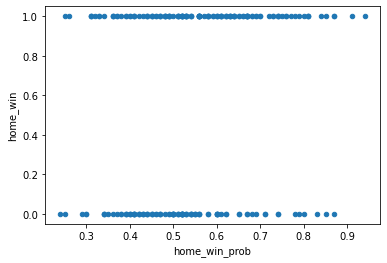

In [9]:
# Plot home win probability vs result

analysis_df.plot.scatter(x='home_win_prob', y='home_win')

      correct_preds  total_games  accuracy
week                                      
2                 4           15  0.266667
3                10           16  0.625000
4                 5           13  0.384615
5                11           15  0.733333
6                 8           13  0.615385
7                 6           11  0.545455
8                 9           13  0.692308
9                 6           11  0.545455
10                5           13  0.384615
11               11           14  0.785714
12                7           12  0.583333
13                6           11  0.545455
14                8           10  0.800000
15                8           15  0.533333
16               10           14  0.714286
17                8           13  0.615385
18                9           12  0.750000
19                5            6  0.833333
20                3            4  0.750000
21                0            1  0.000000
22                0            1  0.000000


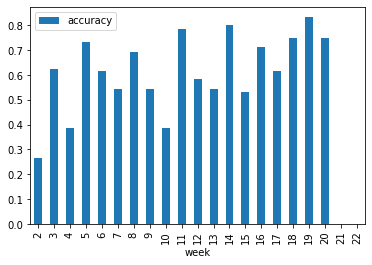

In [10]:
# Week by week accuracy

weekly = analysis_df.groupby(by='week').agg(correct_preds=('pred_correct', 'sum'), total_games=('pred_correct', 'count'))
weekly['accuracy'] = weekly.correct_preds/weekly.total_games
print(weekly)
weekly.plot.bar(y='accuracy')

In [11]:
# Average Confidence
# When correctly predicting a win, how confident were we in the prediction on average?
# Likewise, when incorrect, how confident were we?

pred_confs = analysis_df.groupby(by=['pred_correct', 'home_win']).mean()[['home_win_prob', 'away_win_prob']]
pred_confs

home_win_prob  away_win_prob
pred_correct home_win                              
0            0              0.612200       0.387800
             1              0.409091       0.590909
1            0              0.413400       0.586600
             1              0.645618       0.354382

In [12]:
# Bring in the gambling data, see how we would have fared with actual betting
# Also, compare accuracy for favorites, underdogs, etc.

betting = pd.read_csv('../data/betting_data_cleaned_with_returns.csv')
betting = betting.drop(columns=['Unnamed: 0'])

In [13]:
game_probs = base[['date', 'season', 'week', 'home', 'away', 'home_win', 'home_win_pred', 'home_win_prob', 'away_win_prob']]

In [14]:
len(game_probs)

2064

In [15]:
game_with_lines = betting.merge(game_probs, left_on=['date', 'home_team', 'away_team'], right_on=['date', 'home', 'away'])

In [16]:
game_with_lines['home_line_advantage'] = game_with_lines.apply(lambda x: x.home_win_prob-x.home_implied_prob, axis=1)
game_with_lines['away_line_advantage'] = game_with_lines.apply(lambda x: x.away_win_prob-x.away_implied_prob, axis=1)
# game_with_lines

In [29]:
def get_algo_returns(game, threshold):
    if game.home_line_advantage > game.away_line_advantage:
        bet_team = 'home'
        bet_advantage = game.home_line_advantage
    else:
        bet_team = 'away'
        bet_advantage = game.away_line_advantage
        
    if bet_advantage < threshold:
        return 0 
    
    else:
        return game['{}_return'.format(bet_team)]
    
threshold = 0

game_with_lines['algo_return'] = game_with_lines.apply(lambda x: get_algo_returns(x, threshold), axis=1)

In [30]:
game_with_lines

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.0,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.67,0.33,0.124545,-0.170000,-100.00
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.0,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,0,0.49,0.51,-0.075217,0.033810,-100.00
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.0,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.68,0.32,0.013333,-0.050370,50.00
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.0,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.78,0.22,0.057778,-0.097460,-100.00
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.0,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.61,0.39,-0.181667,0.140000,-100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033,2014-09-14,Cincinnati Bengals,Atlanta Falcons,24,10,34,-242.0,216.0,-5.5,5.5,48.5,under,-14,14,home,0.707602,0.316456,home,41.32,-100.0,41.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2014,2,Cincinnati Bengals,Atlanta Falcons,1,1,0.76,0.24,0.052398,-0.076456,41.32
2034,2014-09-14,Cleveland Browns,New Orleans Saints,26,24,50,197.0,-220.0,4.5,-4.5,49.5,over,-2,2,home,0.336700,0.687500,home,-100.00,197.0,197.00,-100.00,-100.00,90.91,90.91,-100.00,90.91,-100.00,2014,2,Cleveland Browns,New Orleans Saints,1,1,0.78,0.22,0.443300,-0.467500,197.00
2035,2014-09-14,Minnesota Vikings,New England Patriots,7,30,37,148.0,-164.0,3.5,-3.5,49.0,under,23,-23,away,0.403226,0.621212,away,60.98,-100.0,-100.00,60.98,90.91,-100.00,-100.00,90.91,-100.00,90.91,2014,2,Minnesota Vikings,New England Patriots,0,0,0.20,0.80,-0.203226,0.178788,60.98
2036,2014-09-14,Tennessee Titans,Dallas Cowboys,10,26,36,-167.0,151.0,-3.0,3.0,49.5,under,16,-16,away,0.625468,0.398406,away,-100.00,151.0,-100.00,151.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2014,2,Tennessee Titans,Dallas Cowboys,0,0,0.33,0.67,-0.295468,0.271594,151.00


In [31]:
# Test Season total return

test_with_lines = game_with_lines[game_with_lines.season == 2022]

sum(test_with_lines.algo_return)

-1506.8200000000002

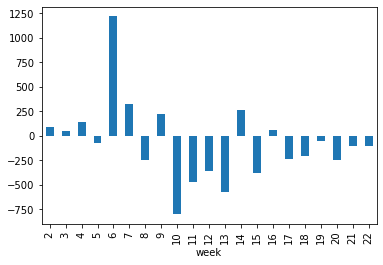

In [32]:
# Week by week return 
test_with_lines.groupby(by='week').sum()['algo_return'].plot.bar()

In [46]:
test_with_lines[test_with_lines.week == 10]

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return
112,2022-11-14,Philadelphia Eagles,Washington Football Team,21,32,53,-526.0,400.0,-11.0,11.0,43.0,over,11,-11,away,0.840256,0.200000,away,-100.00,400.0,-100.00,400.0,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,10,Philadelphia Eagles,Washington Football Team,0,1,0.83,0.17,-0.010256,-0.030000,0.0
113,2022-11-13,San Francisco 49ers,Los Angeles Chargers,22,16,38,-370.0,290.0,-8.0,8.0,45.5,under,-6,6,away,0.787234,0.256410,home,27.03,-100.0,27.03,-100.0,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,10,San Francisco 49ers,Los Angeles Chargers,1,1,0.60,0.40,-0.187234,0.143590,-100.0
114,2022-11-13,Green Bay Packers,Dallas Cowboys,31,28,59,170.0,-200.0,3.5,-3.5,44.5,over,-3,3,home,0.370370,0.666667,home,-100.00,170.0,170.00,-100.0,-100.00,90.91,90.91,-100.00,90.91,-100.00,2022,10,Green Bay Packers,Dallas Cowboys,1,0,0.31,0.69,-0.060370,0.023333,-100.0
115,2022-11-13,Las Vegas Raiders,Indianapolis Colts,20,25,45,-213.0,175.0,-4.0,4.0,41.0,over,5,-5,away,0.680511,0.363636,away,-100.00,175.0,-100.00,175.0,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,10,Las Vegas Raiders,Indianapolis Colts,0,1,0.87,0.13,0.189489,-0.233636,-100.0
116,2022-11-13,Buffalo Bills,Minnesota Vikings,30,33,63,-263.0,215.0,-6.0,6.0,46.0,over,3,-3,away,0.724518,0.317460,away,-100.00,215.0,-100.00,215.0,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,10,Buffalo Bills,Minnesota Vikings,0,1,0.76,0.24,0.035482,-0.077460,-100.0
117,2022-11-13,Chicago Bears,Detroit Lions,30,31,61,-161.0,140.0,-3.0,3.0,48.5,over,1,-1,away,0.616858,0.416667,away,-100.00,140.0,-100.00,140.0,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,10,Chicago Bears,Detroit Lions,0,1,0.75,0.25,0.133142,-0.166667,-100.0
118,2022-11-13,Kansas City Chiefs,Jacksonville Jaguars,27,17,44,-455.0,350.0,-9.5,9.5,51.5,under,-10,10,home,0.819820,0.222222,home,21.98,-100.0,21.98,-100.0,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,10,Kansas City Chiefs,Jacksonville Jaguars,1,1,0.73,0.27,-0.089820,0.047778,-100.0
119,2022-11-13,Miami Dolphins,Cleveland Browns,39,17,56,-172.0,150.0,-3.0,3.0,49.5,over,-22,22,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.0,90.91,-100.00,90.91,-100.00,90.91,-100.00,2022,10,Miami Dolphins,Cleveland Browns,1,1,0.53,0.47,-0.102353,0.070000,-100.0
120,2022-11-13,New York Giants,Houston Texans,24,16,40,-233.0,190.0,-4.5,4.5,41.0,under,-8,8,home,0.699700,0.344828,home,42.92,-100.0,42.92,-100.0,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,10,New York Giants,Houston Texans,1,1,0.57,0.43,-0.129700,0.085172,-100.0
121,2022-11-13,Pittsburgh Steelers,New Orleans Saints,20,10,30,-116.0,-105.0,-1.0,1.0,39.5,under,-10,10,home,0.537037,0.512195,home,86.21,-100.0,86.21,-100.0,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,10,Pittsburgh Steelers,New Orleans Saints,1,0,0.38,0.62,-0.157037,0.107805,-100.0


In [89]:
# Should move these to helper functions later

def get_algo_returns_home(game, threshold):
    if game.home_line_advantage < threshold:
        return 0 
    
    else:
        return game.home_return
    
def get_algo_returns_away(game, threshold):
    if game.away_line_advantage < threshold:
        return 0 
    
    else:
        return game.away_return
    
def get_algo_returns_favorite(game, threshold):
    if game.home_moneyline < game.away_moneyline:
        favorite = 'home'
    else:
        favorite = 'away'
        
    if game['{}_line_advantage'.format(favorite)] < threshold:
        return 0 
    
    else:
        return game.favorite_return 
    
def get_algo_returns_underdog(game, threshold):
    if game.home_moneyline > game.away_moneyline:
        underdog = 'home'
    else:
        underdog = 'away'
        
    if game['{}_line_advantage'.format(underdog)] < threshold:
        return 0 
    
    else:
        return game.underdog_return 
    
threshold = 0

test_with_lines['algo_return_home'] = test_with_lines.apply(lambda x: get_algo_returns_home(x, threshold), axis=1)
test_with_lines['algo_return_away'] = test_with_lines.apply(lambda x: get_algo_returns_away(x, threshold), axis=1)
test_with_lines['algo_return_favorite'] = test_with_lines.apply(lambda x: get_algo_returns_favorite(x, threshold), axis=1)
test_with_lines['algo_return_underdog'] = test_with_lines.apply(lambda x: get_algo_returns_underdog(x, threshold), axis=1)
test_with_lines

<ipython-input-89-9d162d5ba49e>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-9d162d5ba49e>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-9d162d5ba49e>:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-89-9d16

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.00,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.514,0.486,-0.031455,-0.014000,0.0,0.0,0.0,0.0,0.0
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.00,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.511,0.489,-0.054217,0.012810,0.0,0.0,-100.0,0.0,-100.0
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.00,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.683,0.317,0.016333,-0.053370,0.0,50.0,0.0,50.0,0.0
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.00,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.729,0.271,0.006778,-0.046460,0.0,-100.0,0.0,-100.0,0.0
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.00,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.555,0.445,-0.236667,0.195000,0.0,0.0,-100.0,0.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-09-18,Jacksonville Jaguars,Indianapolis Colts,24,0,24,140.0,-161.0,3.0,-3.0,43.5,under,-24,24,home,0.416667,0.616858,home,-100.00,140.00,140.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,2,Jacksonville Jaguars,Indianapolis Colts,1,1,0.579,0.421,0.162333,-0.195858,0.0,140.0,0.0,0.0,140.0
228,2022-09-18,New Orleans Saints,Tampa Bay Buccaneers,10,20,30,125.0,-147.0,2.5,-2.5,43.5,under,10,-10,away,0.444444,0.595142,away,68.03,-100.00,-100.00,68.03,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,2,New Orleans Saints,Tampa Bay Buccaneers,0,1,0.507,0.493,0.062556,-0.102142,0.0,-100.0,0.0,0.0,-100.0
229,2022-09-18,New York Giants,Carolina Panthers,19,16,35,-105.0,-116.0,1.0,-1.0,43.5,under,-3,3,home,0.512195,0.537037,home,-100.00,95.24,95.24,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,2,New York Giants,Carolina Panthers,1,0,0.452,0.548,-0.060195,0.010963,0.0,0.0,-100.0,-100.0,0.0
230,2022-09-18,Pittsburgh Steelers,New England Patriots,14,17,31,135.0,-156.0,3.0,-3.0,40.0,under,3,-3,push,0.425532,0.609375,away,64.10,-100.00,-100.00,64.10,0.00,0.00,0.00,0.00,-100.00,90.91,2022,2,Pittsburgh Steelers,New England Patriots,0,1,0.702,0.298,0.276468,-0.311375,-100.0,-100.0,0.0,0.0,-100.0


In [90]:
# Look at outcomes by home, away, favorite, underdog, etc.

test_pivoted = test_with_lines.copy().reset_index()
test_pivoted = test_pivoted.groupby(by='week').sum().reset_index()
test_pivoted = pd.melt(test_pivoted, id_vars = ['week'],
              value_vars=['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog'],
             var_name='algo_return_type', value_name='return')
test_pivoted

,week,algo_return_type,return
0,2,algo_return_home,215.00
1,3,algo_return_home,-30.00
2,4,algo_return_home,-57.89
3,5,algo_return_home,-340.12
4,6,algo_return_home,690.00
...,...,...,...
79,18,algo_return_underdog,-210.00
80,19,algo_return_underdog,-50.00
81,20,algo_return_underdog,-200.00
82,21,algo_return_underdog,-100.00


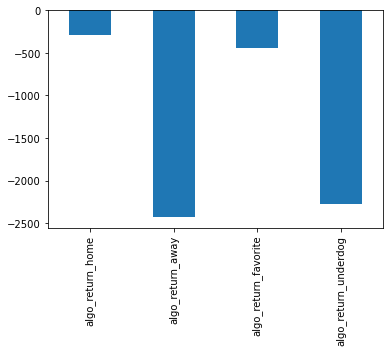

In [91]:
test_with_lines.sum()[['algo_return_home', 'algo_return_away', 'algo_return_favorite', 'algo_return_underdog']].plot.bar()

In [92]:
# Week by week return 

fig = px.bar(test_pivoted, x="week", y="return", color='algo_return_type')
fig.show()

In [93]:
# Get accuracies 

def get_algo_acc(game, column):
    if game[column] > 0:
        return 1
    elif game[column] < 0:
        return 0 
    else:
        return None

test_with_lines['algo_home_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_home'), axis=1)
test_with_lines['algo_away_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_away'), axis=1)
test_with_lines['algo_favorite_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_favorite'), axis=1)
test_with_lines['algo_underdog_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_underdog'), axis=1)
test_with_lines

<ipython-input-93-3ec925f5dcd9>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-93-3ec925f5dcd9>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-93-3ec925f5dcd9>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-93-3ec9

,date,home_team,away_team,home_score,away_score,total_score,home_moneyline,away_moneyline,home_spread,away_spread,total_score.1,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,season,week,home,away,home_win,home_win_pred,home_win_prob,away_win_prob,home_line_advantage,away_line_advantage,algo_return,algo_return_home,algo_return_away,algo_return_favorite,algo_return_underdog,algo_home_acc,algo_away_acc,algo_favorite_acc,algo_underdog_acc
0,2023-02-12,Philadelphia Eagles,Kansas City Chiefs,35,38,73,-120.0,100.0,-1.0,1.0,51.5,over,3,-3,away,0.545455,0.500000,away,-100.00,100.00,-100.00,100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,2022,22,Philadelphia Eagles,Kansas City Chiefs,0,1,0.514,0.486,-0.031455,-0.014000,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2023-01-29,Kansas City Chiefs,Cincinnati Bengals,23,20,43,-130.0,110.0,-2.0,2.0,48.5,under,-3,3,home,0.565217,0.476190,home,76.92,-100.00,76.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,21,Kansas City Chiefs,Cincinnati Bengals,1,1,0.511,0.489,-0.054217,0.012810,0.0,0.0,-100.0,0.0,-100.0,NaN,0.0,NaN,0.0
2,2023-01-22,San Francisco 49ers,Dallas Cowboys,19,12,31,-200.0,170.0,-3.5,3.5,46.5,under,-7,7,home,0.666667,0.370370,home,50.00,-100.00,50.00,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,San Francisco 49ers,Dallas Cowboys,1,1,0.683,0.317,0.016333,-0.053370,0.0,50.0,0.0,50.0,0.0,1.0,NaN,1.0,NaN
3,2023-01-22,Buffalo Bills,Cincinnati Bengals,10,27,37,-260.0,215.0,-6.0,6.0,48.5,under,17,-17,away,0.722222,0.317460,away,-100.00,215.00,-100.00,215.00,-100.00,90.91,-100.00,90.91,-100.00,90.91,2022,20,Buffalo Bills,Cincinnati Bengals,0,1,0.729,0.271,0.006778,-0.046460,0.0,-100.0,0.0,-100.0,0.0,0.0,NaN,0.0,NaN
4,2023-01-21,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,-100.00,26.32,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,2022,20,Philadelphia Eagles,New York Giants,1,1,0.555,0.445,-0.236667,0.195000,0.0,0.0,-100.0,0.0,-100.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-09-18,Jacksonville Jaguars,Indianapolis Colts,24,0,24,140.0,-161.0,3.0,-3.0,43.5,under,-24,24,home,0.416667,0.616858,home,-100.00,140.00,140.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,2,Jacksonville Jaguars,Indianapolis Colts,1,1,0.579,0.421,0.162333,-0.195858,0.0,140.0,0.0,0.0,140.0,1.0,NaN,NaN,1.0
228,2022-09-18,New Orleans Saints,Tampa Bay Buccaneers,10,20,30,125.0,-147.0,2.5,-2.5,43.5,under,10,-10,away,0.444444,0.595142,away,68.03,-100.00,-100.00,68.03,90.91,-100.00,-100.00,90.91,-100.00,90.91,2022,2,New Orleans Saints,Tampa Bay Buccaneers,0,1,0.507,0.493,0.062556,-0.102142,0.0,-100.0,0.0,0.0,-100.0,0.0,NaN,NaN,0.0
229,2022-09-18,New York Giants,Carolina Panthers,19,16,35,-105.0,-116.0,1.0,-1.0,43.5,under,-3,3,home,0.512195,0.537037,home,-100.00,95.24,95.24,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,2022,2,New York Giants,Carolina Panthers,1,0,0.452,0.548,-0.060195,0.010963,0.0,0.0,-100.0,-100.0,0.0,NaN,0.0,0.0,NaN
230,2022-09-18,Pittsburgh Steelers,New England Patriots,14,17,31,135.0,-156.0,3.0,-3.0,40.0,under,3,-3,push,0.425532,0.609375,away,64.10,-100.00,-100.00,64.10,0.00,0.00,0.00,0.00,-100.00,90.91,2022,2,Pittsburgh Steelers,New England Patriots,0,1,0.702,0.298,0.276468,-0.311375,-100.0,-100.0,0.0,0.0,-100.0,0.0,NaN,NaN,0.0


In [94]:
accs = test_with_lines.groupby(by='week').agg(
    algo_home_correct = ('algo_home_acc', 'sum'),
    algo_home_total = ('algo_home_acc', 'count'),
    algo_away_correct = ('algo_away_acc', 'sum'),
    algo_away_total = ('algo_away_acc', 'count'),
    algo_favorite_correct = ('algo_favorite_acc', 'sum'),
    algo_favorite_total = ('algo_favorite_acc', 'count'),
    algo_underdog_correct = ('algo_underdog_acc', 'sum'),
    algo_underdog_total = ('algo_underdog_acc', 'count')
)

accs['algo_home_acc'] = accs.algo_home_correct/accs.algo_home_total
accs['algo_away_acc'] = accs.algo_away_correct/accs.algo_away_total
accs['algo_favorite_acc'] = accs.algo_favorite_correct/accs.algo_favorite_total
accs['algo_underdog_acc'] = accs.algo_underdog_correct/accs.algo_underdog_total

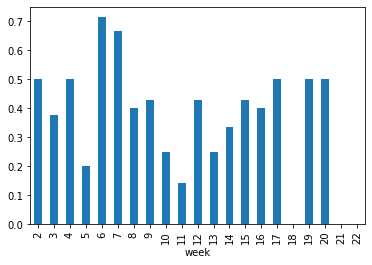

In [95]:
check_col = 'algo_home_acc'
accs[check_col].plot.bar()

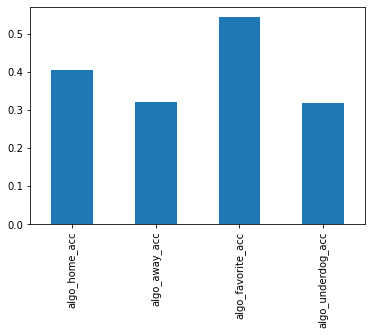

In [96]:
accs2 = test_with_lines.agg(['sum','count']).transpose().loc[['algo_home_acc', 'algo_away_acc', 'algo_favorite_acc', 'algo_underdog_acc']]
accs2['accuracy'] = accs2['sum']/accs2['count']
accs2.accuracy.plot.bar()

In [ ]:
# NOTE

do some eda, maybe 6 games isnt the best number
maybe would be good to use previous season data for the early weeks as well
can look at autocorrelation? see how the correlation between stats changes the farther the number of games is
may find that after 4 or 5 games the correlation gets very small, or maybe the opposite